In [627]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.imputation import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
import random
import matplotlib.pyplot as plt

In [628]:
def makeUserTarget(df, user):
    aux = []
    for _, row in df.iterrows():
        if row.our_data == 0:
            if(np.floor(row.SessionID/100).astype(int) == user):
                aux.append(1)
            else:
                aux.append(0)
        else:
            if 'Diego' in row.SessionID and user == 'Diego':
                aux.append(1)
            elif 'Toto' in row.SessionID and user == 'Toto':
                aux.append(1)
            elif (('Jo' in row.SessionID) or ('jo' in row.SessionID)) and user == 'Jo':
                aux.append(1)
            else:
                aux.append(0)
    df['target'] = aux

In [629]:
def separateIntoTrainAndTest(df, test_sessions = []):
    targetSessionIds = list(df[df.target == 1].SessionID.unique())
    targetChoosenSession = random.choice(targetSessionIds)
    notTargetSessionIds = list(df[df.target == 0].SessionID.unique())
    notTargetChoosenSessions = test_sessions
    for i in range(2):
        notTargetChoosenSession = random.choice(notTargetSessionIds) 
        notTargetChoosenSessions.append(notTargetChoosenSession)
        notTargetSessionIds.remove(notTargetChoosenSession)
    df_train = df[(df.SessionID != targetChoosenSession) & (~df.SessionID.isin(notTargetChoosenSessions))]
    df_test = df[(df.SessionID == targetChoosenSession) | (df.SessionID.isin(notTargetChoosenSessions))]
    
    return df_train, df_test

In [630]:
def getOurDataUsers(row):
    if 'Diego' in row.SessionID :
        return('Diego')
    elif 'Toto' in row.SessionID:
        return('Toto')
    elif ('Jo' in row.SessionID) or ('jo' in row.SessionID):
        return('Jo')

In [631]:
file_name = '../aggregated_features'
our_data_file_name = '../our_data_aggregated_features'
to_drop = []
df = pd.read_csv('./' + file_name + '.csv')
our_data_df = pd.read_csv('./' + our_data_file_name + '.csv')
df['our_data'] = 0
our_data_df['our_data'] = 1

In [632]:
users = (np.floor(df.SessionID/100).astype(int)).unique()
our_data_users = our_data_df.apply(getOurDataUsers,axis=1)

In [633]:
df = df.append(our_data_df,ignore_index=True)

In [634]:
df = df[df.our_data != 0]

In [635]:
sessionsToDrop = ['Diego01','Diego02','Diego03']

In [636]:
df = df[~df.SessionID.isin(sessionsToDrop)]

In [639]:
#user = random.choice(users)
user = 'Toto'
makeUserTarget(df, user)

In [638]:
#to_drop =  ['our_data','Contact_size_mean','Contact_size_std'] 
to_drop =  ['our_data','Mag_Z_mean','Mag_X_mean','Mag_Y_mean','Mag_Y_std','Mag_Z_std','Mag_X_std']

In [640]:
clf = xgb.XGBClassifier(n_estimators=90, max_depth=9, random_state=31, colsample_bytree=0.6, colsample_bylevel=0.5, learning_rate=0.11, subsample=0.9)
#clf = RandomForestClassifier()

In [621]:
df_train, df_test = separateIntoTrainAndTest(df,test_sessions=['Toto6'])

In [622]:
df_train = df_train.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)
df_test = df_test.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)

In [623]:
x_train, y_train = df_train.drop("target", axis=1), df_train["target"]

In [624]:
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.6, gamma=0, learning_rate=0.11, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=31, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [625]:
x_test, y_test = df_test.drop("target", axis=1), df_test["target"]

In [626]:
x_test

Acc_X_mean  Acc_X_std  Acc_Y_mean  Acc_Y_std  \
SessionID WindowNumber                                                 
Jo1       0.0            -0.140530   0.315243    6.062770   0.229442   
          1.0            -0.179086   0.265640    6.189682   0.248793   
          2.0            -0.414848   0.295180    6.197247   0.231040   
          3.0            -0.112451   0.248214    5.822641   0.334695   
          4.0            -0.552218   0.342608    5.368911   0.293293   
          5.0            -0.342888   0.353068    5.576134   0.223726   
          6.0            -0.491980   0.399826    5.628385   0.245831   
          7.0            -0.491099   0.717804    5.702414   0.362552   
          8.0            -0.313218   0.324920    5.115367   0.355031   
          9.0            -0.208943   0.242267    5.623820   0.285565   
          10.0           -0.333407   0.220384    5.553035   0.234589   
          11.0           -0.211092   0.267824    5.802836   0.228664   
          12.0           -0.126567   0.273509    5.723962   0.253315   
          13.0           -0.068627   0.259500    5.767325   0.198867   
          14.0           -0.188395   0.386060    5.768034   0.226235   
          15.0           -0.155968   0.295990    5.877210   0.230358   
          16.0           -0.095500   0.202055    5.420837   0.332442   
          17.0           -0.061004   0.216407    5.585634   0.298585   
          18.0           -0.284565   0.313166    5.191510   0.233740   
          19.0           -0.306707   0.347034    5.593047   0.269250   
Toto6     0.0            -0.602190   0.308930    3.245771   0.317987   
          1.0            -0.396480   0.435345    3.175669   0.311486   
          2.0            -0.465433   0.314878    3.237344   0.317485   
          3.0            -0.658310   0.423174    3.339816   0.229740   
          4.0            -0.576524   0.188241    3.533267   0.218180   
          5.0            -0.243640   0.278384    3.114856   0.264444   
          6.0            -0.718337   0.450561    3.233092   0.345282   
          7.0            -0.817859   0.272040    3.554508   0.163875   
          8.0            -0.790562   0.359600    3.205760   0.195897   
          9.0            -0.696848   0.372080    2.944019   0.217932   
...                            ...        ...         ...        ...   
jo5       18.0                 NaN        NaN         NaN        NaN   
          19.0                 NaN        NaN         NaN        NaN   
          20.0                 NaN        NaN         NaN        NaN   
          21.0                 NaN        NaN         NaN        NaN   
          22.0                 NaN        NaN         NaN        NaN   
          23.0                 NaN        NaN         NaN        NaN   
          24.0                 NaN        NaN         NaN        NaN   
          25.0                 NaN        NaN         NaN        NaN   
          26.0                 NaN        NaN         NaN        NaN   
          27.0                 NaN        NaN         NaN        NaN   
          28.0                 NaN        NaN         NaN        NaN   
          29.0                 NaN        NaN         NaN        NaN   
          30.0                 NaN        NaN         NaN        NaN   
          31.0                 NaN        NaN         NaN        NaN   
          32.0                 NaN        NaN         NaN        NaN   
          33.0                 NaN        NaN         NaN        NaN   
          34.0                 NaN        NaN         NaN        NaN   
          35.0                 NaN        NaN         NaN        NaN   
          36.0                 NaN        NaN         NaN        NaN   
          37.0                 NaN        NaN         NaN        NaN   
          38.0                 NaN        NaN         NaN        NaN   
          39.0                 NaN        NaN         NaN        NaN   
          40.0                 NaN        NaN         NaN       

In [598]:
predict = clf.predict_proba(x_test)

In [599]:
df_predict = pd.DataFrame(clf.predict_proba(x_test)[:, 1], columns=["prob"], index=x_test.index)

In [600]:
df_socorro = df_predict.merge(df_test[['target']], right_index=True, left_index=True)

In [601]:
df_socorro[df_socorro.target == 0].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
Diego05,25.0,0.106868,0
Jo1,9.5,0.101049,0


In [602]:
df_socorro[df_socorro.target == 1].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
Toto6,10.0,0.818796,1
Toto8,18.5,0.904097,1


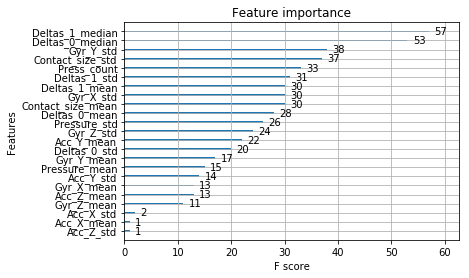

In [603]:
xgb.plot_importance(clf)
plt.figure()

In [604]:
i_pred_proba = clf.predict_proba(x_test)
auc = roc_auc_score(y_test, i_pred_proba[:, 1])

In [605]:
print(auc)

0.971592265457


In [606]:
df_test.reset_index().SessionID.unique()

array(['Diego05', 'Jo1', 'Toto6', 'Toto8'], dtype=object)

In [607]:
df_train.reset_index().SessionID.unique()

array(['Andres1', 'Diego04', 'Toto1', 'Toto10', 'Toto2', 'Toto5', 'Toto7',
       'Toto9', 'jo2', 'jo3', 'jo4', 'jo5'], dtype=object)